In [1]:
import os
import sys

path = os.getcwd()
par_path = os.path.abspath(os.pardir)
sys.path.append(par_path)

from utils.data import ExtractROI, AtlasDataset

import matplotlib.pyplot as plt
import numpy as np
import torch

import csv
import math
import random as rand
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from models.unet import UNet
from models.moment_unet import *

## **Extract ROIs**

You will need to manually delete the save directories in order to regenerate to ROIs as a precaution against accidentally running and overwriting. 

In [2]:
# Extract ROIs and ensure the ROIs' assigned label is the center of the ROI
ROI_size = (64, 64)
sampling_rate = 0.5
str_sampling_rate = str(sampling_rate).replace('.', '_')

extract_dir = '/nafs/dtward/allen/npz_files/'
save_dir = '/nafs/dtward/allen/rois/'
sub_save_dir = f"{ROI_size[0]}x{ROI_size[1]}_sample_rate_{str_sampling_rate}_center/"
abs_save_dir = os.path.join(save_dir, sub_save_dir)

if not os.path.exists(abs_save_dir):
    os.makedirs(abs_save_dir)
    extractor_center = ExtractROI(extract_dir=extract_dir, save_dir=abs_save_dir)
    extractor_center.extract_ROI(ROI_size=ROI_size, sampling_rate=sampling_rate, label_mode='center')
else:
    print(f"{abs_save_dir} already exists. If you intend to re-extract the ROIs, please delete the directory first.")

# Extract ROIs and ensure the ROIs' assigned labels are maintained as an n x n where each pixel is some label (segmentation)
ROI_size = (64, 64)
sampling_rate = 0.5
str_sampling_rate = str(sampling_rate).replace('.', '_')

extract_dir = '/nafs/dtward/allen/npz_files/'
save_dir = '/nafs/dtward/allen/rois/'
sub_save_dir = f"{ROI_size[0]}x{ROI_size[1]}_sample_rate_{str_sampling_rate}_all/"
abs_save_dir = os.path.join(save_dir, sub_save_dir)

if not os.path.exists(abs_save_dir):
    os.makedirs(abs_save_dir)
    extractor_all = ExtractROI(extract_dir=extract_dir, save_dir=abs_save_dir)
    extractor_all.extract_ROI(ROI_size=ROI_size, sampling_rate=sampling_rate, label_mode='all')
else:
    print(f"{abs_save_dir} already exists. If you intend to re-extract the ROIs, please delete the directory first.")

# Extract ROIs and ensure the ROIs' assigned label is the mode of all the labels in the ROI
ROI_size = (64, 64)
sampling_rate = 0.5
str_sampling_rate = str(sampling_rate).replace('.', '_')

extract_dir = '/nafs/dtward/allen/npz_files/'
save_dir = '/nafs/dtward/allen/rois/'
sub_save_dir = f"{ROI_size[0]}x{ROI_size[1]}_sample_rate_{str_sampling_rate}_mode/"
abs_save_dir = os.path.join(save_dir, sub_save_dir)

if not os.path.exists(abs_save_dir):
    os.makedirs(abs_save_dir)
    extractor_all = ExtractROI(extract_dir=extract_dir, save_dir=abs_save_dir)
    extractor_all.extract_ROI(ROI_size=ROI_size, sampling_rate=sampling_rate, label_mode='mode')
else:
    print(f"{abs_save_dir} already exists. If you intend to re-extract the ROIs, please delete the directory first.")

/nafs/dtward/allen/rois/64x64_sample_rate_0_5_center/ already exists. If you intend to re-extract the ROIs, please delete the directory first.
/nafs/dtward/allen/rois/64x64_sample_rate_0_5_all/ already exists. If you intend to re-extract the ROIs, please delete the directory first.
/nafs/dtward/allen/rois/64x64_sample_rate_0_5_mode/ already exists. If you intend to re-extract the ROIs, please delete the directory first.


## **Dataloader**

In [3]:
train_dir = '/nafs/dtward/allen/rois/64x64_sample_rate_0_5_all/train/'
test_dir = '/nafs/dtward/allen/rois/64x64_sample_rate_0_5_all/test/'
label_map_file = '/nafs/dtward/allen/rois/substructures.csv' # divisions.csv, organs.csv, structures.csv, substructures.csv, categories.csv

train_dataset = AtlasDataset(data_dir=train_dir, label_map_file=label_map_file)
test_dataset = AtlasDataset(data_dir=test_dir, label_map_file=label_map_file)

bs = 16
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

xinc: torch.Size([1, 24, 64, 64])
x1: torch.Size([1, 48, 32, 32])
x2: torch.Size([1, 96, 16, 16])
x3: torch.Size([1, 192, 8, 8])
x4: torch.Size([1, 384, 4, 4])
x after up1: torch.Size([1, 192, 8, 8])
x after up2: torch.Size([1, 96, 16, 16])
x after up3: torch.Size([1, 48, 32, 32])
x after up4: torch.Size([1, 24, 64, 64])
torch.Size([1, 2, 64, 64])


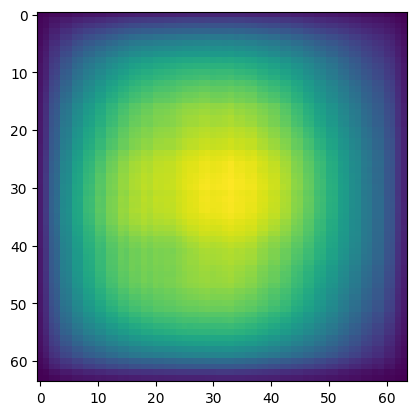

In [18]:
# 3 x 64 x 64 tensor with random stuff
test_tensor = torch.rand(3, 64, 64).unsqueeze(0)
#test_tensor = next(iter(train_loader))[0]   

model = MomentUNet(img_channels=3, n0=16, num_classes=2) 
#model = UNet(img_channels=3, n0=64, num_classes=2)
model.eval()

# Forward pass
output = model(test_tensor)
print(output.shape)

plt.imshow(output[0, 1, :, :].detach().numpy())